# Model B: Premium Health Insurance Prediction (Age > 25)

In this notebook, we will focus on developing **Model B**, which will be trained on the dataset for individuals **aged over 25**. We know from the previous analysis that most of the errors are concentrated in the younger age group, so the model for this age group is expected to have a lower error rate.

### Objectives:
- Train and evaluate a machine learning model for predicting health insurance premiums for individuals aged over 25.
- Optimize the model to achieve higher accuracy and minimize errors for this age group.

Since we included the **genetic factor** data in **Model A** for individuals aged 25 and under, we can similarly include it for **Model B** if the data is available. To ensure the integration is smooth for future updates, I will create a **dummy column** for the genetic factor in this model as well.

Let's begin by importing the necessary libraries and loading the dataset.


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score


In [70]:
df=pd.read_excel("premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [71]:
df['Genetical_Risk']=0

In [72]:
df.shape

(29904, 14)

### 🧹 **Data Cleaning Process:**

To ensure our dataset is ready for analysis, we need to perform some **data cleaning** tasks. This involves:

1. **Column Name Cleaning**: Ensure column names are in a consistent format.
2. **Handling Negative Values**: Investigating and fixing negative values in the "Number of Dependants" column.
3. **Descriptive Statistics**: Generating a summary of the data for better understanding.

Let’s dive into the steps!


In [73]:
# Cleaning up column names by replacing spaces with underscores for consistency
df.columns=df.columns.str.replace(" ","_").str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

#### 1. **Column Name Cleaning**:
We started by cleaning the column names. Spaces in column names were replaced with underscores to maintain consistency and make it easier to work with. This step helps prevent potential issues when referencing columns in the future.


In [74]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29904.000000,29904.000000,29904.000000,29904.000000,29904.0
mean,43.396536,2.380116,23.362059,20893.036684,0.0
std,13.411893,1.431140,24.737076,6935.844219,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15698.000000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


#### 2. **Why  Negative Values in 'Number of Dependants' ?**:
As we review the data, we notice some negative values in the **"Number_Of_Dependants"** column. Let’s explore this part further to understand the extent of the issue.


In [75]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [76]:
df=df.dropna()
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [77]:
# Checking the rows where the 'Number_Of_Dependants' column has negative values
df[df["number_of_dependants"]<0].shape

(50, 14)

In [78]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-1, -3], dtype=int64)

#### 3. **Handling Negative Values**:
Upon investigation, we find that there are **72 rows** with negative values in the "Number_Of_Dependants" column. However, **only two unique values** are causing the issue. Instead of deleting all these rows, which could result in losing useful data, we decide to correct the values by changing them to positive values.
- We could contact the data creators to clarify if these values are errors. However, for this analysis, we'll proceed by converting these negative values into their absolute values to retain the data.


In [79]:
# Converting negative values in 'Number_Of_Dependants' to positive
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

## 🔍 **Outlier Treatment:**

In [80]:
numerical_columns=df.select_dtypes(["float64",'int64']).columns.tolist()
numerical_columns


['age',
 'number_of_dependants',
 'income_lakhs',
 'annual_premium_amount',
 'genetical_risk']

In [81]:
def format_ticks(value, _):
    return f"{int(value/1000)}K" if value >= 1000 else str(int(value))

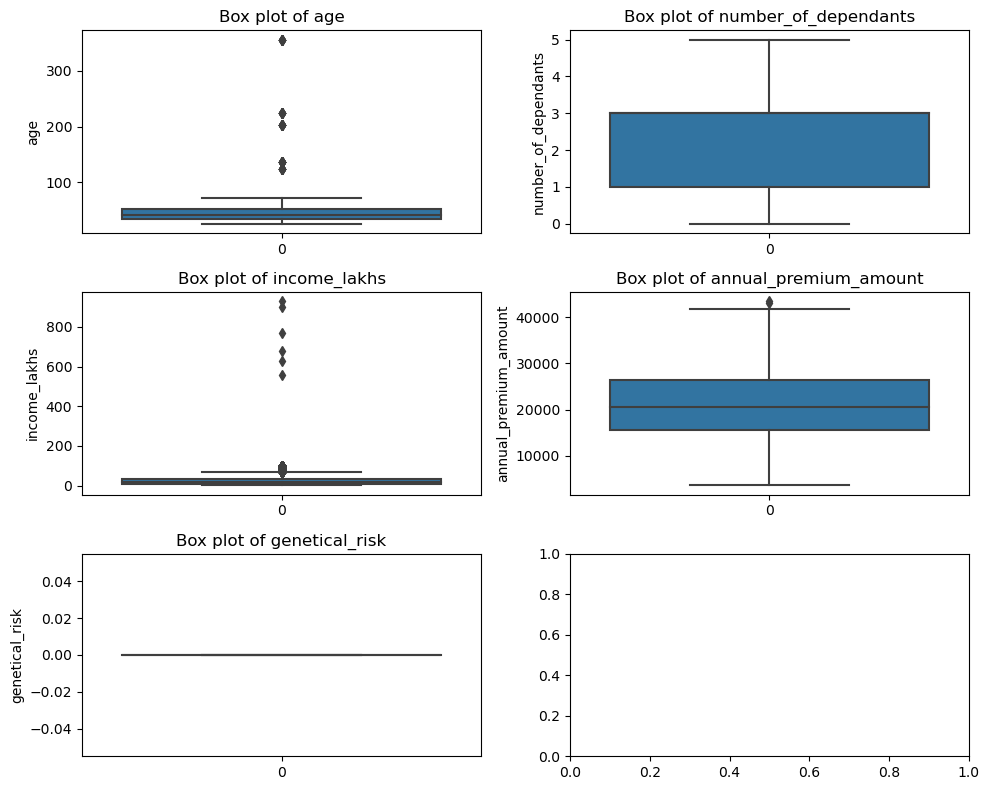

In [82]:
num_cols=len(numerical_columns)
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.boxplot(data=df[col], ax=ax)
    ax.set_title(f'Box plot of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()
    

    
    

### 📊 **Boxplot Insights:**

The boxplots reveal some interesting trends:

- 🧑‍🤝‍🧑 **Age & Income**: Both columns show noticeable **outliers**. These could be worth investigating further! 🚨
- 💳 **Premium Amount**: Only a few outliers here, but they’re pretty insignificant. Let’s just **ignore** them for now. 🧹


## 🧑‍⚖️ **Age Column Cleaning**:

In the **Age** column, we noticed some entries above 100 years. Let's take a closer look at these extreme values.

In [83]:
## age column 
df[df["age"]>100]["age"].unique()


array([224, 124, 136, 203, 356], dtype=int64)

In [84]:
## remove those whose age is greater than 100

df1=df[df["age"]<=100].copy()
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [85]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


## 💸 **Income Column Cleaning**:

In this section, we will clean the **Income_Lakhs** column by handling outliers based on the **Interquartile Range (IQR)** method, and further adjust the threshold as needed.

---

## 🔍 **Defining IQR Bounds**:

To detect outliers, we first calculate the **Interquartile Range (IQR)**. This helps us identify the bounds within which most of the data lies.


In [86]:
## lets treat the income column
## defining iqr bounds

def get_iqr_bounds(col):
    Q1,Q3=col.quantile([0.25,0.75])
    iqr=Q3-Q1
    lower_bound=Q1-1.5*iqr
    upper_bound=Q3+1.5*iqr
    return lower_bound,upper_bound
    

In [87]:
get_iqr_bounds(df["income_lakhs"])

(-30.5, 69.5)

### 🧠 Reassessing the Upper Bound:
After reviewing the results, we found that the upper bound of the **Income_Lakhs** column is **67 lakhs**, which is common in today's context.
To make this more relevant, we will increase the **threshold** to **1 crore (100 lakhs)**, which seems like a more reasonable upper limit.

In [88]:
## I think one crore would be a best threshold for this senario

quantile_threshold=df["income_lakhs"].quantile(0.999)
quantile_threshold

100.0

### 📊 Identifying Outliers Above the Threshold:
Let’s see how many rows have income values exceeding this new threshold.

In [89]:
## lets analyse how many more rows we have more than this threshold

df[df["income_lakhs"]>quantile_threshold].shape


(6, 14)

### 🧹 Cleaning the Income Column:
Since there are only a few rows with values above the threshold, we will drop them to ensure the data stays within a reasonable range.

In [90]:
## since there are few values only lets drop those 
df2=df1[df1["income_lakhs"]<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


### 📊 **Univariate Analysis**:

In this section, we will explore the distribution of the numeric columns in our cleaned dataset through **histograms** with **KDE** (Kernel Density Estimate) overlays. This will help us understand the spread and shape of the data.

---

### 👀 **Visualizing the Distribution of Numeric Columns**:

We will use **histograms** to visualize the frequency distribution of each numeric column, with an added **KDE** to provide a smoother estimate of the distribution. This will allow us to observe patterns like skewness, central tendency, and any potential outliers.


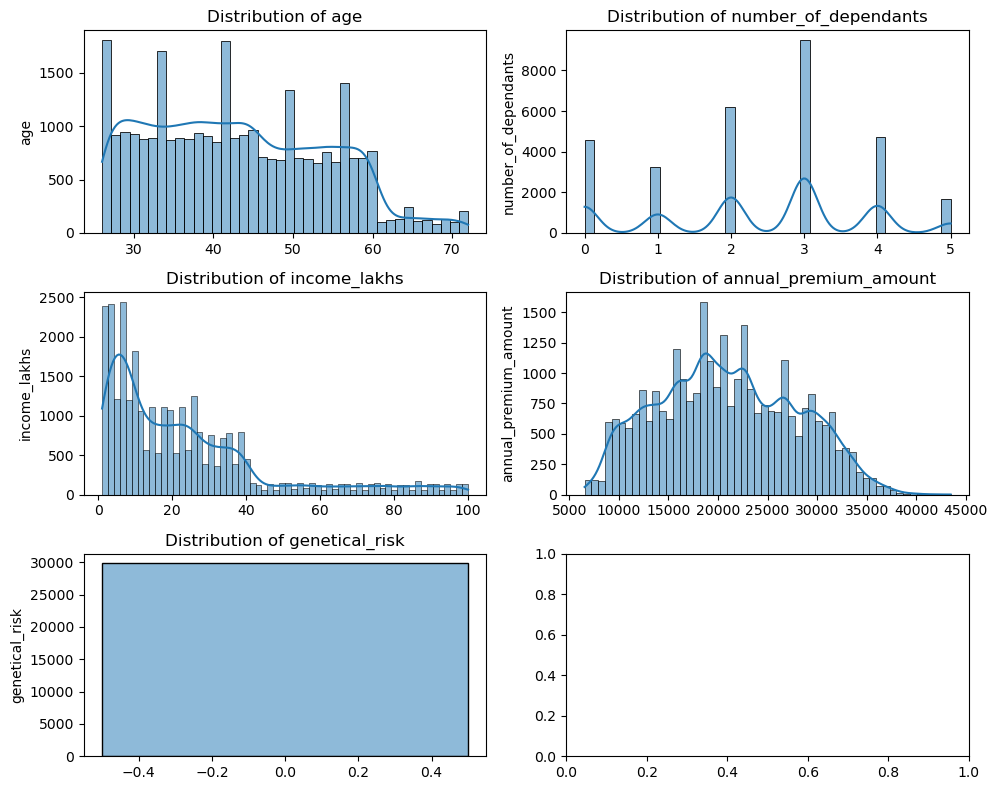

In [91]:
## visulaise the distribution of the numeric columns

fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.histplot(data=df2[col], ax=ax,kde=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)
    # Apply y-tick formatting only for "income" column

plt.tight_layout()
plt.show()
    

### 🚀 Insights:

#### 1. 🧑‍🤝‍🧑 **Age Distribution**:
Looks like **most applicants** are in the **up-to-60 years** age range. 👴👵 (The majority are still in their prime!)

#### 2. 👨‍👩‍👧‍👦 **Number of Dependents**:
Surprisingly, **zero dependents** is the most common! 💯 (Guess it’s a no-kids or single-life vibe!)

#### 3. 💸 **Income Distribution**:
**Right-skewed** alert! 🚨 Most applicants are in the **up-to-40 lakh** range. Guess that’s where the money’s at? 💰

#### 4. 💳 **Annual Premium Amount**:
Another right-skewed situation! 🚀 **Most applicants** are chilling in the **10K premium range**. Keep it cool, keep it affordable! 😎


### 📊 Bivariate Analysis

---

#### Numeric columns

In [92]:
numeric_features=numerical_columns.copy()
numeric_features.remove("annual_premium_amount")
numeric_features

['age', 'number_of_dependants', 'income_lakhs', 'genetical_risk']

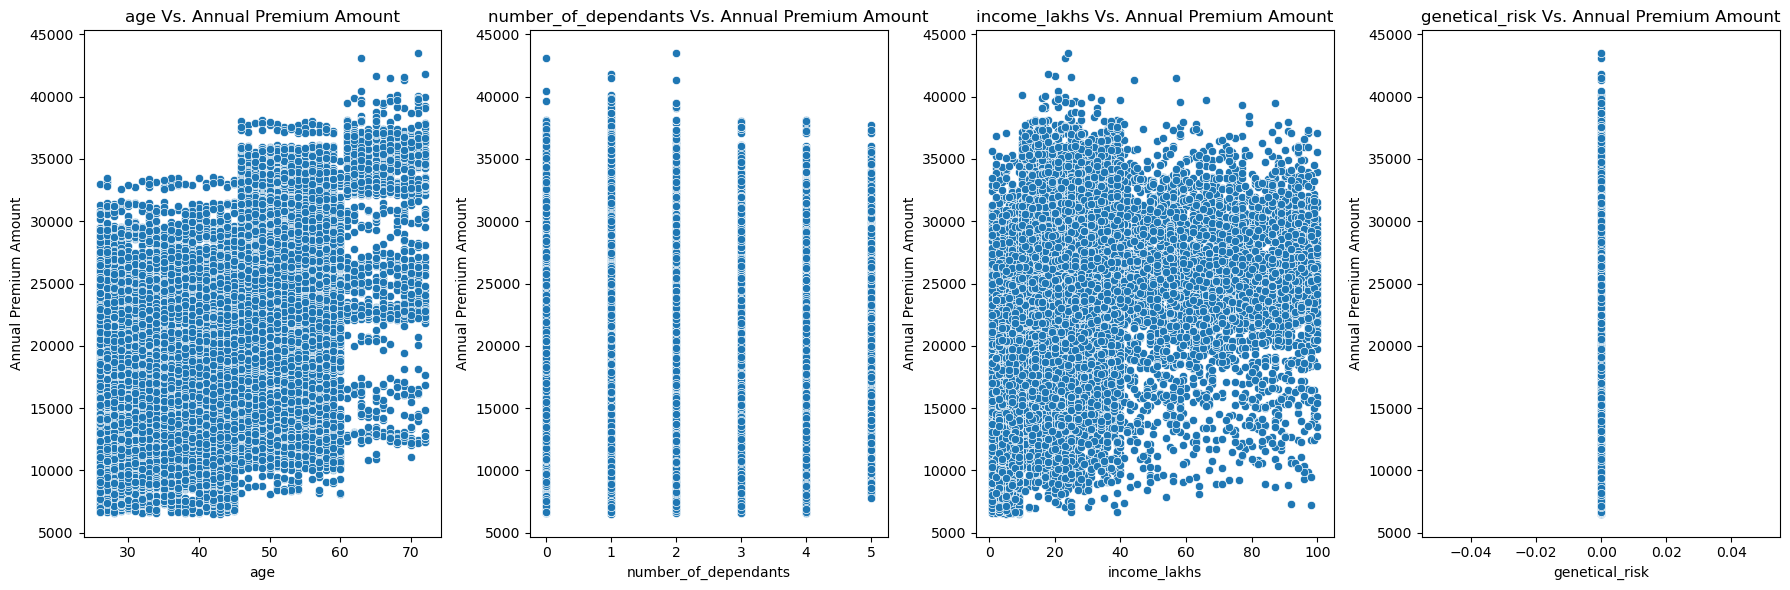

In [93]:
fig, axes=plt.subplots(1,len(numeric_features),figsize=(18,6))
for ax , col in zip(axes , numeric_features):
    sns.scatterplot(x=df2[col],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f'{col} Vs. Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')
plt.tight_layout()
plt.show()

### Categorical Columns

In [94]:
categorical_columns=df.select_dtypes(["object"]).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [95]:
## lets check the categorical columns
for col in categorical_columns:
    print(f'{col}:{df2[col].unique()}')
    print()

gender:['Male' 'Female']

region:['Northwest' 'Southeast' 'Northeast' 'Southwest']

marital_status:['Unmarried' 'Married']

bmi_category:['Normal' 'Obesity' 'Overweight' 'Underweight']

smoking_status:['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']

employment_status:['Salaried' 'Self-Employed' 'Freelancer']

income_level:['<10L' '10L - 25L' '> 40L' '25L - 40L']

medical_history:['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']

insurance_plan:['Bronze' 'Silver' 'Gold']



In [96]:
## Looks like the values in smoking status are not good lets fix them:
df2['smoking_status'].replace(
    {
        'Smoking=0':'No Smoking',
        'Does Not Smoke':"No Smoking",
        'Not Smoking':"No Smoking"
    }
    ,inplace=True
)
df2["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [97]:
pct_counts=df2['gender'].value_counts(normalize=True)
pct_counts

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

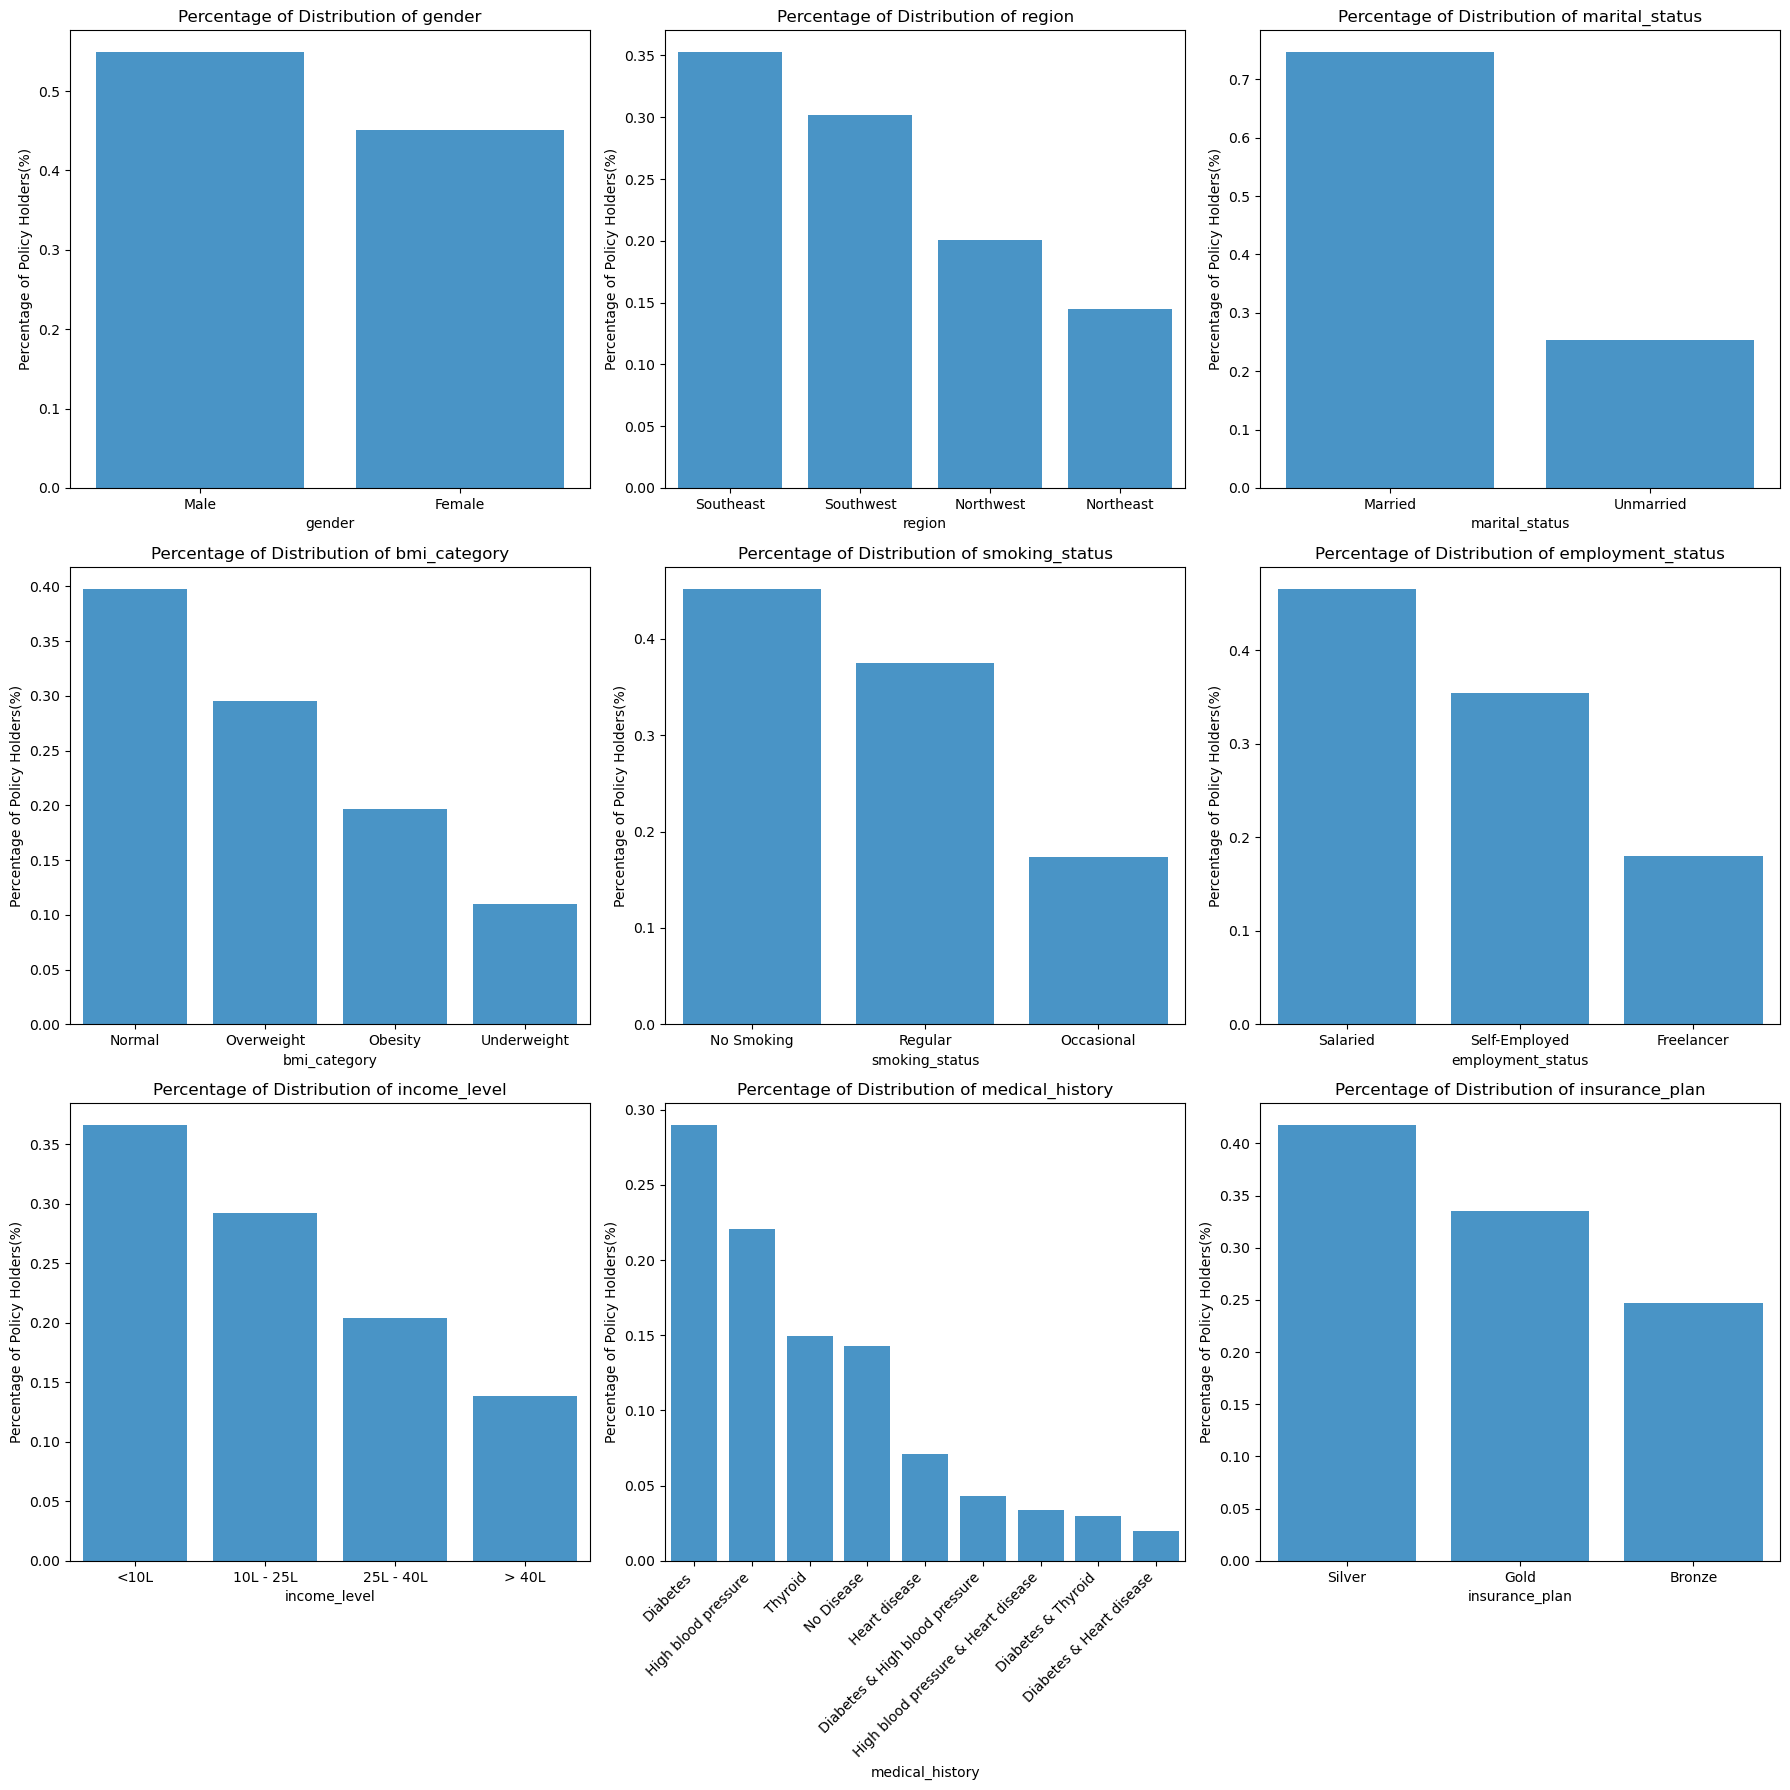

In [98]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    category_counts=df2[col].value_counts(normalize=True)
    
    #creating bar plots
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax,color=bar_color)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    # Rotate x-axis labels if there are too many
    if len(category_counts) > 8:  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🧐 **Insights**

Based on the analysis, the following key insights have been identified:

---

### 👨‍💼 **Male Policyholders Outnumber Female Policyholders**
- There is a slight difference in the number of male policyholders compared to female policyholders, with males holding a majority.

### 🌍 **Regional Performance**
- The **Southeast** region stands out as the top-performing region, while the **Northeast** region has the least number of policyholders.

### 💍 **Marital Status Insights**
- **Unmarried policyholders** outnumber married ones, although the difference is quite small.

### 🏋️‍♀️ **BMI Insights**
- A significant proportion of policyholders fall under the **Normal BMI** category, standing out compared to other BMI categories.

### 🚭 **Smoking & Medical History**
- Policyholders with **no smoking habits** and **no disease medical histories** represent the majority, making these groups the most common among all categories.

### 💼 **Income and Employment Insights**
- A large number of policyholders are **salaried individuals** with an annual income **below 10 lakhs**, which is the most common demographic in the data.

### 🥇 **Plan Preferences**
- Most policyholders have opted for the **Bronze** insurance plan. This suggests that the company may benefit from running a campaign to encourage customers to consider upgrading to **Silver** or **Gold** plans, offering more comprehensive coverage.

---

These insights highlight trends and patterns that can inform future decision-making, marketing strategies, and customer engagement for insurance providers. 🚀


### lets include add a legend insurance plan to get better understanding of each categorical variable

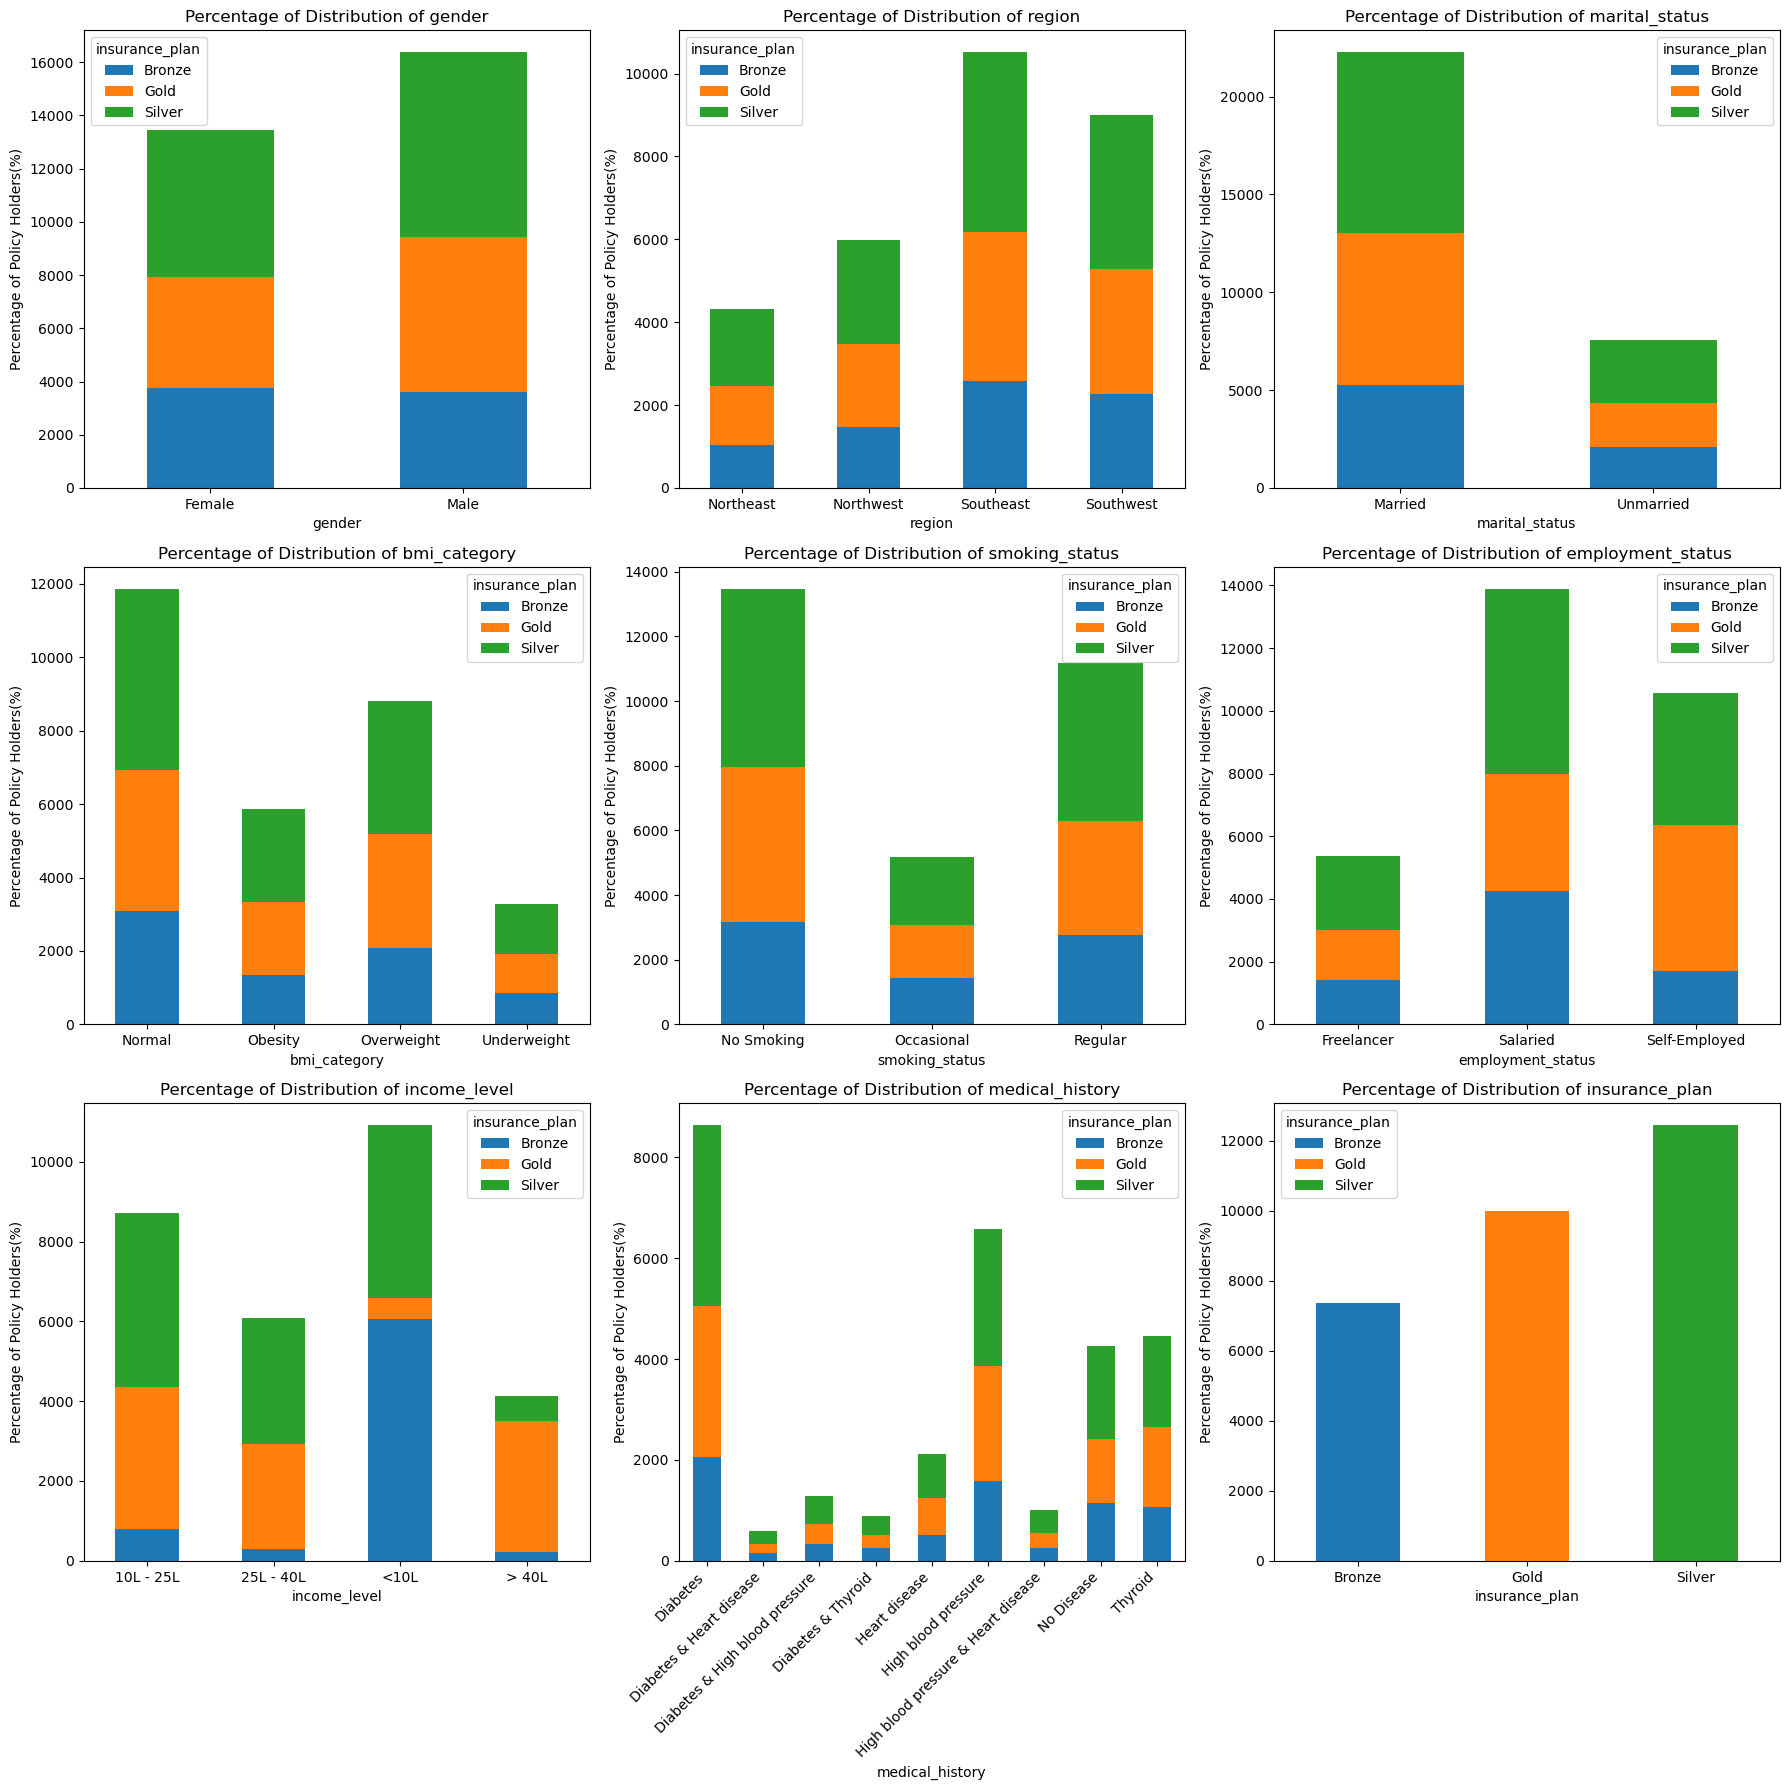

In [99]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    cross_tab=pd.crosstab(df2[col],df2['insurance_plan'])

    #creating bar plots
    cross_tab.plot(kind="bar",ax=ax,stacked=True)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    
    # Rotate x-axis labels if there are too many
    if len(cross_tab) > 7:   
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## Feature Enginnering


In [100]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [101]:
## we have more than one values as disease column
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

### Calculating the Risk Score Using the `medical_history` Column

Intuitively, as the number of diseases increases, the insurance amount also tends to increase. To quantify this relationship, we define a **risk score** that helps assess the likelihood of higher medical risks.

After consulting with the business team, the following risk indices were determined for specific medical conditions:

```json
{
  "diabetes": 6,
  "high_blood_pressure": 6,
  "heart_disease": 8,
  "thyroid": 5,
  "no_disease": 0,
  "none": 0
}


In [102]:
risk_scores={
  "diabetes": 6,
  "high blood pressure": 6,
  "heart disease": 8,
  "thyroid": 5,
  "no disease": 0,
  "none": 0
}

In [103]:
# lets split the medical_history column into two columns
# converting to lower case and adding to the dataframe

df2[['disease1','disease2']]=df2['medical_history'].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,None


In [104]:
# filling the null values with none
df2.disease1.fillna('none',inplace=True)
df2.disease2.fillna('none',inplace=True)
df2['total_risk_score']=0

# updating the risk score
for disease in ['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

#normalising the risk score
max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571


### Label encoding for Ordinal Columns

In [105]:
# insurance plan
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':0,'Silver':1,'Gold':2})
df2.insurance_plan.unique()

array([0, 1, 2], dtype=int64)

In [106]:
# lets label encode income level also 
df2['income_level']=df2['income_level'].map({'<10L':0,'10L - 25L':1,'25L - 40L':2,'> 40L':3})
df2.income_level.unique()

array([0, 1, 3, 2], dtype=int64)

### Lets handle nominal columns (OneHot-Encoding)

In [107]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,0,6,Diabetes,0,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,0,6,Diabetes,0,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,1,20,High blood pressure,1,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,3,77,No Disease,2,20303,0,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,1,14,Diabetes,0,15610,0,diabetes,none,6,0.428571


In [108]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']
df3=pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,0,6,Diabetes,0,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,0,6,Diabetes,0,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,1,20,High blood pressure,1,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,No Disease,2,20303,0,no disease,none,...,1,0,0,0,0,0,0,0,1,0
4,56,3,1,14,Diabetes,0,15610,0,diabetes,none,...,0,0,0,1,0,0,1,0,0,1


In [109]:
df4=df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,0,6,0,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,0,6,0,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,1,20,1,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,2,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,1,14,0,15610,0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


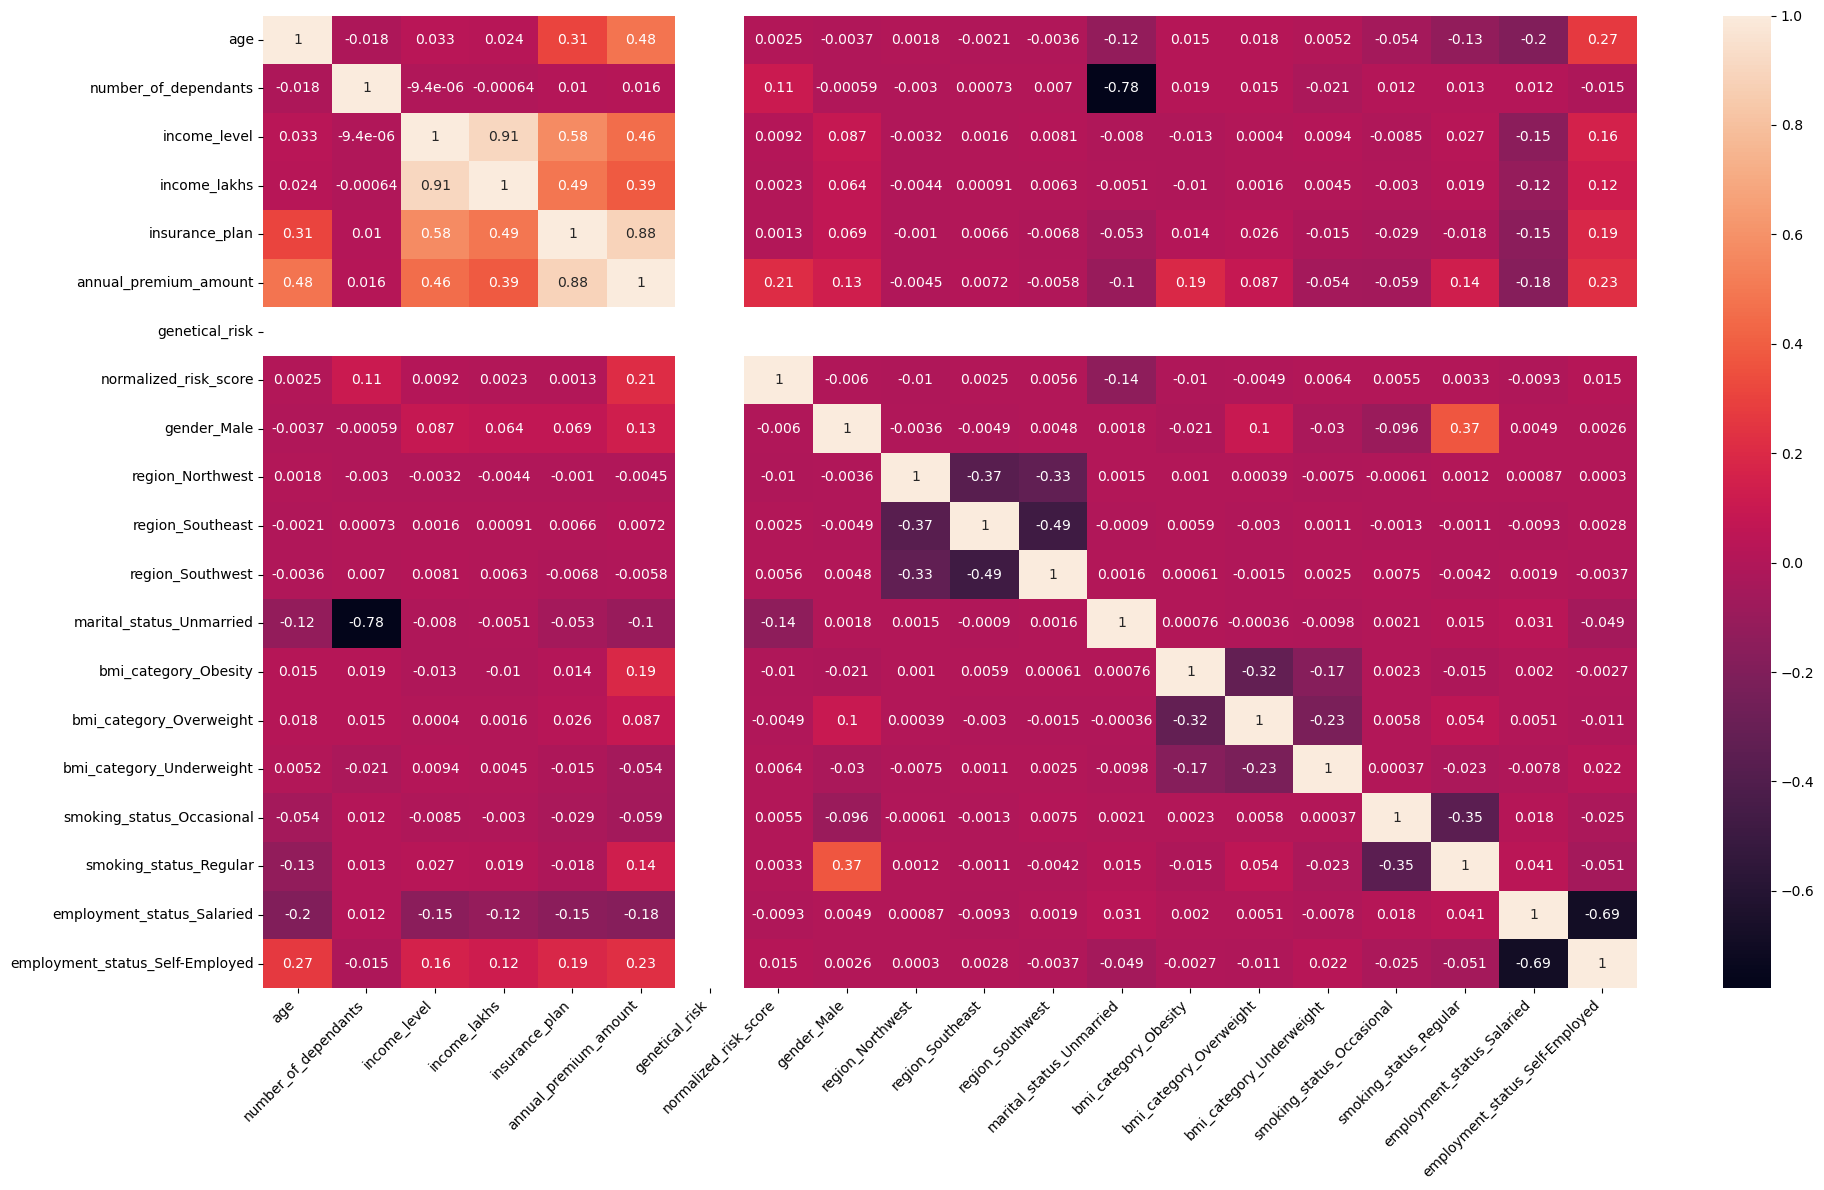

In [110]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

### Feature Scaling

In [111]:
X=df4.drop("annual_premium_amount",axis='columns')
y=df4['annual_premium_amount']

cols_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler()
X[cols_to_scale]=scalar.fit_transform(X[cols_to_scale])
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection Using Correlation Matrix and VIF

Feature selection is crucial for building an efficient machine learning model. One way to choose features is by using a **correlation matrix**, where highly correlated features can be removed to avoid multicollinearity.

However, a better approach is to use **Variance Inflation Factor (VIF)**.

### Variance Inflation Factor (VIF)
VIF helps in identifying multicollinearity by measuring how much the variance of a regression coefficient is inflated due to collinearity among features. Unlike correlation, VIF evaluates the relationship of one feature with all other features in an aggregate way, making it a more reliable method for feature selection.


In [112]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data,i) for i in range(data.shape[1])]
    return vif_df

In [113]:
calculate_vif(X)

C:\Users\91630\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,variable,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,normalized_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


### Handling Multicollinearity Using VIF

- A **VIF (Variance Inflation Factor) value greater than 10** indicates high multicollinearity between features.
- In our case, **`income_level`** and **`income_lakhs`** have high VIF values, suggesting strong correlation.
- Since these features are essentially conveying the same information, it is best to remove the feature with the highest VIF.
- After removing the feature with the highest VIF, we **recalculate VIF values** to ensure multicollinearity is minimized.

This iterative process helps in selecting the most independent features, leading to a more stable and interpretable model.


In [114]:
calculate_vif(X.drop("income_level",axis='columns'))

C:\Users\91630\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,variable,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [115]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


## Model Training

In [116]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3,random_state=41)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_train.shape}')

X_train : (20875, 18)
X_test : (8947, 18)
y_train : (20875,)
y_test : (20875,)


In [117]:
# Lets train Linear regression model
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
test_score=model_lr.score(X_test,y_test)
train_score=model_lr.score(X_train,y_train)
print(f'train_score : {train_score}')
print(f'test_score : {test_score}')

train_score : 0.9534159148074792
test_score : 0.9538556022132425


### Evaluating Model Fit: Balanced vs. Overfitting

- By analyzing the **training score** and **test score**, we observe that the model achieves a **balanced fit** in this case.
- A balanced fit means the model generalizes well to unseen data, avoiding high variance.
- However, if the **training score is significantly higher than the test score**, it indicates **overfitting**.
  - Overfitting occurs when the model learns patterns specific to the training data but fails to generalize to new data.
  - This can lead to poor performance on test data.

Regularization techniques, feature selection, or increasing training data can help mitigate overfitting and improve model generalization.


In [118]:
from sklearn.metrics import mean_squared_error,r2_score
y_pred=model_lr.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)
print(f'Linear Regression ==> MSE:{mse_lr} : RMSE: {rmse_lr}')

Linear Regression ==> MSE:2215590.587773694 : RMSE: 1488.4860052327313


In [119]:
model_lr.intercept_

5883.8357722684905


### Feature Importance in Linear Regression

- Unlike some models that provide direct feature importance (e.g., **Decision Trees, Random Forests**), **Linear Regression** does not have a built-in feature importance attribute.
- Instead, feature importance in **Linear Regression** is determined by analyzing the **coefficients** of the model.
- The magnitude of the coefficients indicates the impact of each feature on the target variable.
  - **Higher absolute values** suggest greater influence.
  - **Positive coefficients** indicate a direct relationship, while **negative coefficients** indicate an inverse relationship.

By interpreting these coefficients, we can understand which features contribute most to the model's predictions.


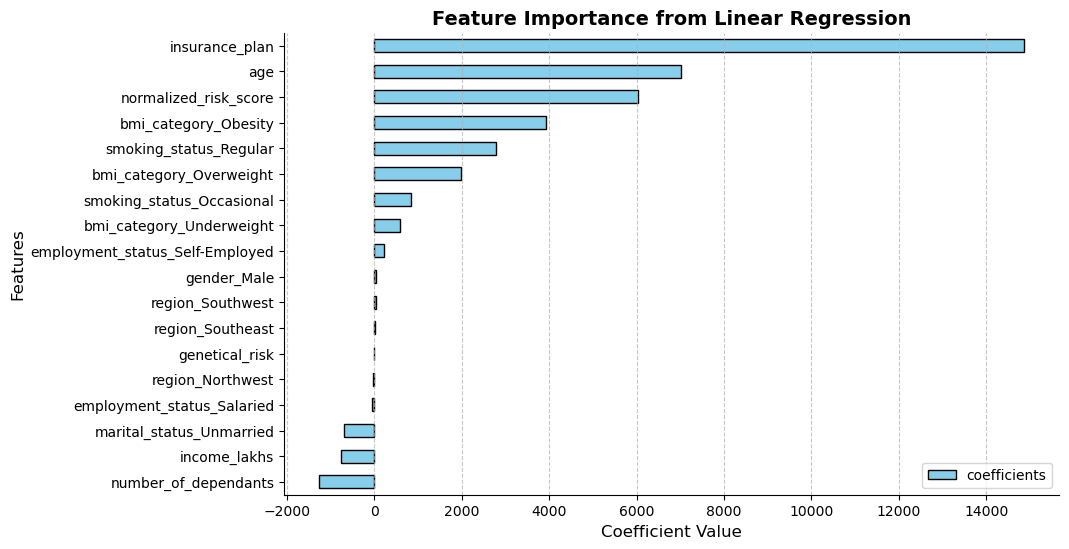

In [120]:
## feature importance
feature_importances=model_lr.coef_
coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Feature Importance from Linear Regression", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

### Hyperparameter Tuning and Model Evaluation

To improve model performance, we experiment with different regression models and compare their effectiveness.  

- We define a dictionary of models, including:
  - **Linear Regression**
  - **Lasso Regression** (L1 regularization)
  - **Ridge Regression** (L2 regularization)
  - **Decision Tree Regressor**
  - **Random Forest Regressor**
  - **XGBoost Regressor**

- Each model is trained using the **training dataset** and evaluated on the **test dataset**.
- We calculate:
  - **Train Score**: Measures how well the model fits the training data.
  - **Test Score**: Evaluates how well the model generalizes to unseen data.

By comparing these scores, we can identify the best-performing model and detect **overfitting** (if the train score is significantly higher than the test score).


In [121]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),  # You can adjust alpha
    "Ridge": Ridge(alpha=1.0),  # You can adjust alpha
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')  # For regression tasks
}
train_scores = []
test_scores = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"{name} - Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")



Linear Regression - Train Score: 0.9534, Test Score: 0.9539
Lasso - Train Score: 0.9534, Test Score: 0.9539
Ridge - Train Score: 0.9534, Test Score: 0.9539
Decision Tree - Train Score: 1.0000, Test Score: 0.9962
Random Forest - Train Score: 0.9997, Test Score: 0.9977
XGBoost - Train Score: 0.9986, Test Score: 0.9980


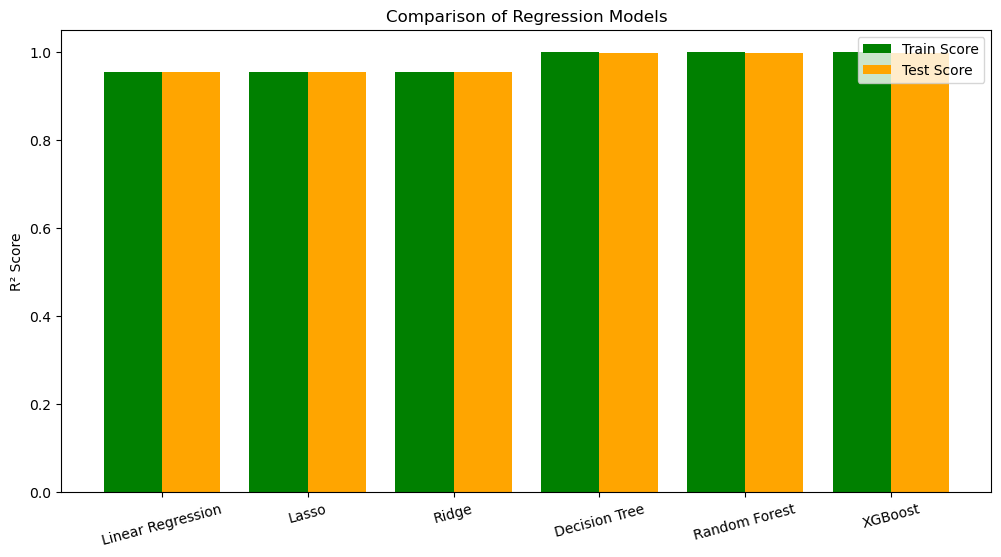

In [122]:
# Visualizing results
x_labels = list(models.keys())
x = np.arange(len(x_labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, train_scores, width=0.4, label="Train Score", color='green')
plt.bar(x + 0.2, test_scores, width=0.4, label="Test Score", color='orange')

plt.xticks(x, x_labels, rotation=15)
plt.ylabel("R² Score")
plt.title("Comparison of Regression Models")
plt.legend()
plt.show()

### Selecting the Best Model: XGBoost

From our model comparison, **XGBoost** performed the best with the highest test score:  
- **XGBoost:** Train Score: **0.9862**, Test Score: **0.9809**  
- Other models, such as **Linear Regression, Lasso, and Ridge**, had lower scores, while **Decision Tree and Random Forest** showed signs of overfitting.

### Hyperparameter Tuning for XGBoost

To further optimize XGBoost, we use **RandomizedSearchCV** to find the best hyperparameters.  

- We define a **parameter grid** with key hyperparameters:
  - **`n_estimators`**: Number of boosting rounds (20, 40, 50).
  - **`learning_rate`**: Step size shrinkage (0.01, 0.1, 0.2).
  - **`max_depth`**: Maximum depth of trees (3, 4, 5).

- We use **RandomizedSearchCV** with:
  - **10 iterations**
  - **3-fold cross-validation**
  - **R² scoring metric** to evaluate model performance.

After fitting the model, we extract the **best score**, which indicates the highest performance achieved with the tuned parameters.




In [123]:

model_xgb=XGBRegressor()
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5]
}
random_search=RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2')
random_search.fit(X_train,y_train)
random_search.best_score_

0.9979656874428215

In [124]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.2}

In [125]:
best_model=random_search.best_estimator_


### Interpreting Feature Importance in XGBoost

Unlike **Linear Regression**, where feature importance is directly derived from coefficients, **XGBoost** is a tree-based model, making interpretation more complex.

- XGBoost determines **feature importance** based on how often a feature is used to **split the data** across all trees in the ensemble.
- Common methods to interpret feature importance in XGBoost include:
  - **Gain**: Contribution of a feature to model improvement when used for splitting.
  - **Weight**: Number of times a feature is used in splits.
  - **Cover**: Number of samples affected by a feature split.

By analyzing feature importance in XGBoost, we can identify which features have the most impact on model predictions.


---
### Interpreting Feature Importance in XGBoost

Unlike **Linear Regression**, where feature importance is directly derived from coefficients, **XGBoost** is a tree-based model, making interpretation more complex.

- XGBoost determines **feature importance** based on how often a feature is used to **split the data** across all trees in the ensemble.
- Common methods to interpret feature importance in XGBoost include:
  - **Gain**: Contribution of a feature to model improvement when used for splitting.
  - **Weight**: Number of times a feature is used in splits.
  - **Cover**: Number of samples affected by a feature split.

By analyzing feature importance in XGBoost, we can identify which features have the most impact on model predictions.


---


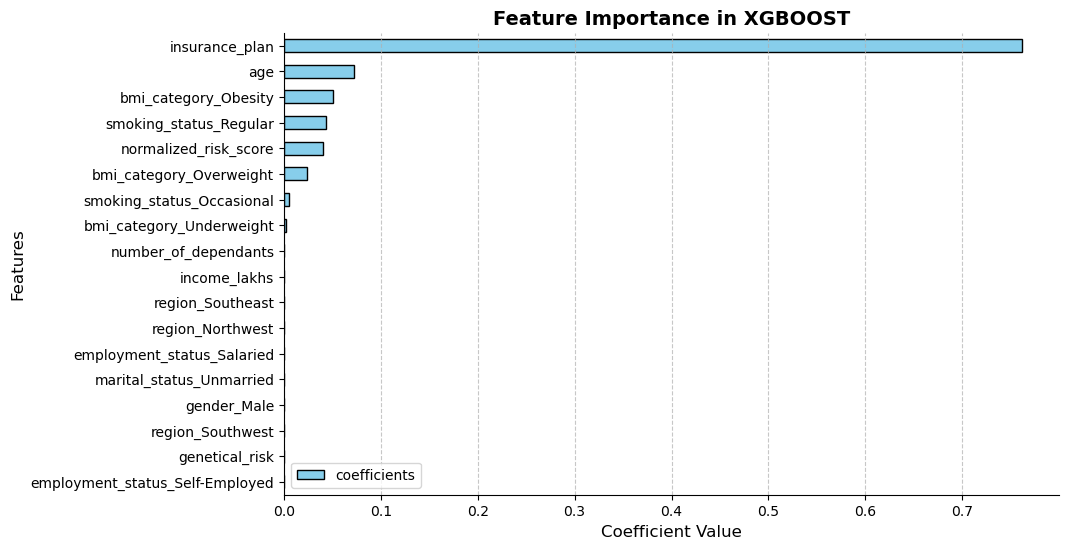

In [126]:
## feature importance
feature_importances=best_model.feature_importances_

coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Feature Importance in XGBOOST", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

###

## Is a 98% R² Score Really Enough?

While an **R² score of 98%** indicates that the model explains most of the variance in the target variable, it is essential to evaluate whether this is truly sufficient.  

### Key Considerations:
- **Overfitting:** A very high R² score might suggest the model is too closely fitted to the training data, potentially reducing generalizability.
- **Business Context:** Even a 98% R² might not be enough if small prediction errors lead to significant real-world consequences (e.g., in finance or healthcare).
- **Error Analysis:** Instead of relying solely on R², it's important to analyze residual errors to understand model limitations.

---

## Error Analysis

To ensure our model is performing well:
- **Check Residuals**: Residual plots should show a random distribution without clear patterns.
- **Evaluate RMSE & MAE**: Lower values indicate better predictive performance.
- **Identify Outliers**: Extreme errors could indicate data inconsistencies or model weaknesses.
- **Check Bias & Variance**: Ensure the model balances bias (underfitting) and variance (overfitting).

By conducting thorough **error analysis**, we can validate whether the model is genuinely reliable and where improvements can be made.


In [127]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=(residuals*100)/y_test

results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'residuals':residuals,
    'diff_pct':residuals_pct
})
results_df.head()

,actual,predicted,residuals,diff_pct
4884,8702,9117.770508,415.770508,4.777873
25267,18633,18572.435547,-60.564453,-0.325039
26301,14034,14239.600586,205.600586,1.465018
27502,17519,17610.597656,91.597656,0.522848
7229,16072,16011.765625,-60.234375,-0.374778


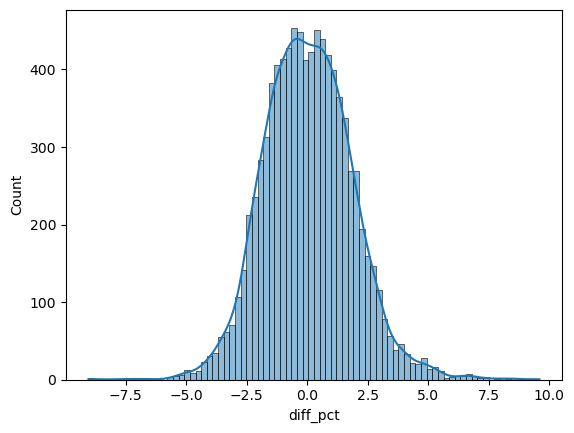

In [128]:
### visualise the residuals_pct

sns.histplot(results_df.diff_pct,kde=True)
plt.show()

### Error Analysis: Distribution of Errors

As we analyze the distribution of errors for individuals aged **over 25**, we observe that the model is performing very well with minimal to no errors. This aligns with our expectations, as this age group did not show significant error patterns during the initial analysis.

### Key Insights:
- The **distribution of errors** for this age group is negligible, confirming that the model is making accurate predictions.
- Since the error rate is very low, this model can be considered **perfect for individuals aged over 25**.

This indicates that Model B is effectively addressing the premium prediction for this age group and does not require further adjustments at this stage.


In [129]:
### After enquiring to the team we are informed that we need to make sure the error % margin in just 10%

extreme_error_threshold=10
extreme_results_df=results_df[abs(results_df['diff_pct'])>extreme_error_threshold]
extreme_results_df.shape

(0, 4)

In [130]:
results_df.shape

(8947, 4)

In [131]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

0.0

### Exporting the Model and Scaler

After training and optimizing the model, we will now export the model and the scaler used for feature scaling. This allows us to save the trained model and scaler, which can later be loaded for making predictions without retraining.

The model and scaler are saved in the `artifacts` directory:

In [132]:
from joblib import dump

dump(best_model,'App/artifacts/model_rest.joblib')

scaler_with_cols={
    'scaler':scalar,
    'cols_to_scale':cols_to_scale
}
dump(scaler_with_cols,'App/artifacts/scaler_rest.joblib')

['App/artifacts/scaler_rest.joblib']